<center><font size="6"><b>Showcasing new validation strategy</b></font></center>

## Model training strategy

1. Multi-linear regression
2. Kernel regression
3. Kernel ridge regression
4. Lasso regression
5. Genetic programming
6. Neural network

We will try the multi-linear and kernel regression first as our base-line model optimized, and then follow by parameter regulation methods like Kerel Ridge and Lasso regression. Apart from the methods which had been already introduced in the lectures, we will go further to newral network method. These 3 methods are covered in our imporved model. Our goal is to determine the best hyperparameters for each model based on the $r_{square}$ values of testsets.

## Model validation strategy

1. hold-out
2. k-fold
3. bootstrapping

Currently 25% of our original dataset is randomly assign as validation set which would not be modified or changed throughout the training-testing process. In our final report, we will probabibly select datapoints where there is a significant difference between the rigid/flexible models to see if the models can also predict extreme cases. We will do validations (the above 3 methods) based on the determined hyperparameters for all the training strategies. That will also be covered in our final report.

# Unchanged codes
Unchanged codes are lumped together below.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
np.set_printoptions(precision=3,suppress=True)
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

In [2]:
# read the 36-descriptor data
df36Descriptor = pd.read_excel('data/ML_data/descriptor_used.xlsx',header=4,index_col=1)

# clean up the column
columns = [df36Descriptor.columns[1]] + df36Descriptor.columns[3: -11].tolist()

newColumns = {}
for ci in columns:
    if ' ' in ci:
        newColumns[ci] = ci.split(' ',1)[0]
    elif '(' in ci:
        newColumns[ci] = ci.split('(',1)[0]
    else:
        newColumns[ci] = ci

dfShortNames = df36Descriptor[columns].rename(columns=newColumns)

# reduce columns to only contain MOF features
shared_descriptor = [col for col in dfShortNames.columns if col in newColumns]
dfMLReduced = dfShortNames[shared_descriptor]

# the MOFs in "dfMLReduced" and adsorption data sets are different, so it is necessary to match the MOFs in two datasets
def datasetMatch(MOFName):
    dfML= dfMLReduced[dfMLReduced['MOF'].isin(MOFName)].drop_duplicates()
    matchedMOFIndex=np.isin(MOFName, dfML['MOF'].values)
    return matchedMOFIndex, dfML

# read flexibility data
flexibilityList=os.listdir('data/flexibility_data/y_data/adsorption_data') # obtain list of csv files for 9 adsorption uptakes
flexivilityData=[]
adsorbateNameList = []

for i, name in enumerate(flexibilityList):
    # read csv files for certain adsorption uptakes
    df = pd.read_csv('data/flexibility_data/y_data/adsorption_data/' + name)
    
    # obtain the rigid value
    rigidValue = np.array(df[df.columns[1]], dtype = float)
    
    # obtain the flexible mean value
    flexValue = np.mean(np.array(df[df.columns[2:]],dtype=float),axis=1)
    
    # obtain the adsorbate label
    label = np.array([name.split("_")[1] for x in range(0,len(flexValue))],dtype=str)
    adsorbateNameList.append(name.split("_")[1])
    
    # stack the rigid value, flexible mean value and the adsorbate label
    singleSet = np.column_stack([rigidValue,flexValue,label])

    if i == 0:
        # obtain the name list of MOFs
        MOFNameTemp = np.array(df[df.columns[0]], dtype = str)
        MOFName = [x.split("_")[0] for x in MOFNameTemp]
        
        # search the MOF name in "dfMLReduced", generating dfML
        matchedMOFIndex, dfML = datasetMatch(MOFName)
        print("The number of MOFs shared by two datasets are: {:d}.".format(dfML.shape[0]))
        
        # generating flexibilityData as "y"
        flexibilityData = singleSet[matchedMOFIndex,:].copy()
    else:
        # concatenate "y"
        flexibilityData = np.concatenate([flexibilityData.copy(),singleSet[matchedMOFIndex,:].copy()])

# manually add adsorbate descriptors

# Mw/gr.mol-1, Tc/K, Pc/bar, ω, Tb/K, Tf/K

adsorbateData=np.array([
    ['xenon',131.293,289.7,58.4,0.008,164.87,161.2], 
    ['butane',58.1,449.8,39.5,0.3,280.1,146.7], 
    ['propene',42.1,436.9,51.7,0.2,254.8,150.6], 
    ['ethane',30.1,381.8,50.3,0.2,184.0,126.2], 
    ['propane',44.1,416.5,44.6,0.2,230.1,136.5], 
    ['CO2',44.0,295.9,71.8,0.2,317.4,204.9], 
    ['ethene',28.054,282.5,51.2,0.089,169.3,228], 
    ['methane',16.04,190.4,46.0,0.011,111.5,91],
    ['krypton',83.798,209.4,55.0,0.005,119.6,115.6]])

adsorbateData.shape
adDf = pd.DataFrame(data=adsorbateData, columns=["adsorbate", "Mw/gr.mol-1", "Tc/K", "Pc/bar", "ω", "Tb/K", "Tf/K"])

# sort the dataframe based on adsorbateNameList
sorterIndex = dict(zip(adsorbateNameList,range(len(adsorbateNameList))))
adDf['an_Rank'] = adDf['adsorbate'].map(sorterIndex)
adDf.sort_values(['an_Rank'],ascending = [True], inplace = True)
adDf.drop('an_Rank', 1, inplace = True)
adDfFloat = adDf.iloc[:, 1:].astype(np.float)
adDfFloat["adsorbate"] = adDf["adsorbate"]


# replicate dfML for 9 adsorbates
dfMLReplicate = pd.concat([dfML]*9)

# replicate adDf for 89 MOFs
adDfReplicate = pd.DataFrame(np.repeat(adDfFloat.values,89,axis=0))
adDfReplicate.columns = adDfFloat.columns

# concatenate two datasets
dfMLReplicate.reset_index(drop=True, inplace=True)
adDfReplicate.reset_index(drop=True, inplace=True)
XAllDescriptor = pd.concat([dfMLReplicate, adDfReplicate],axis=1)

X = np.concatenate((XAllDescriptor.iloc[:, 1:-1], flexibilityData[:, 0].reshape(-1, 1)),axis=1).astype(np.float)
y = flexibilityData[:, 1].astype('float64') .reshape(-1,1)


# feature scaling
X_scaled = (X - X.mean(axis=0))/X.std(axis=0) 

XAllDescriptor.head()
flexibilityData

The number of MOFs shared by two datasets are: 89.


array([['2.842392813', '2.7255026209065', 'butane'],
       ['2.086272931', '3.1063526610226666', 'butane'],
       ['1.472946691', '2.0552884249058887', 'butane'],
       ...,
       ['14.15219967', '13.821848680833336', 'xenon'],
       ['6.662372437', '6.378310010356667', 'xenon'],
       ['6.65909719', '6.326572230466223', 'xenon']], dtype='<U32')

# data set split
## Validation set split

In [3]:
np.random.seed(5)
from sklearn.model_selection import train_test_split

# combine the unscaled and scaled X, so that they can be split together
X_combined = np.concatenate((X, X_scaled), axis=1)

# ---------------------------- don't touch the validation set ----------------------------
X_train_test_combined, X_validation_combined, y_train_test, y_validation = train_test_split(X_combined, \
                                                                                            y, test_size=0.25)
X_train_test, X_train_test_scaled = X_train_test_combined[:, :35], X_train_test_combined[:, 35:]
X_validation, X_validation_scaled = X_validation_combined[:, :35], X_validation_combined[:, 35:]
# ---------------------------- don't touch the validation set ----------------------------

## 5-fold on train-test set

In [4]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle = True)

for i, (train_index, test_index) in enumerate(kf.split(X_train_test_combined)):
    
    # initialize sets
    if i == 0:
        X_train_combined_5fold = np.zeros(X_train_test_combined[train_index].shape + (5,))
        X_test_combined_5fold = np.zeros(X_train_test_combined[test_index].shape + (5,))
        y_train_5fold = np.zeros(y_train_test[train_index].shape + (5,))
        y_test_5fold = np.zeros(y_train_test[test_index].shape + (5,))
        
    X_train_combined_5fold[:, :, i], X_test_combined_5fold[:, :, i] = X_train_test_combined[train_index], X_train_test_combined[test_index]
    y_train_5fold[:, :, i], y_test_5fold[:, :, i] = y_train_test[train_index], y_train_test[test_index]

X_train_5fold, X_train_scaled_5fold = X_train_combined_5fold[:, :35], X_train_combined_5fold[:, 35:]
X_test_5fold, X_test_scaled_5fold = X_test_combined_5fold[:, :35], X_test_combined_5fold[:, 35:]

# Show how to use 5-fold sets

The code below is only meant for showing how to use 5-fold strategy for training models.
<span style="color:red">They are **not** examples of the whole modeling work</span>.

## Without hyperparameter tuning - using multi-linear regression as example

In [5]:
from sklearn.linear_model import LinearRegression

LR_r2_list = []
LR_coef_list = []

for i in range(5):
    LR_model = LinearRegression()
    LR_model.fit(X_train_5fold[:, :, i], y_train_5fold[:, :, i])
    
    LR_r2_list.append(LR_model.score(X_test_5fold[:, :, i], y_test_5fold[:, :, i]))
    LR_coef_list.append(LR_model.coef_)


best_i = np.array(LR_r2_list).argmax()
LR_coef_best = LR_coef_list[best_i]

for i in range(5):
    if i != best_i:
        print("Fold {}:\tr2={:.3f}".format(i, LR_r2_list[i]))
    else:
        print("Fold {}:\tr2={:.3f}\t<-best performance".format(i, LR_r2_list[i]))

Fold 0:	r2=0.983
Fold 1:	r2=0.984	<-best performance
Fold 2:	r2=0.981
Fold 3:	r2=0.977
Fold 4:	r2=0.970


## With hyperparameter tuning - using rbf kernel regression as example

In [6]:
from sklearn.metrics.pairwise import rbf_kernel

sigmas = np.array([1E-4, 5E-4, 1E-3, 5E-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60])
gammas = 1./(2*sigmas**2)
r2_matrix = np.zeros((gammas.size, 3))

rbf_r2_list = []
rbf_coef_list = []
rbf_gamma_list = []

for i in range(5):
    
    rbf_coef_temp_list = [] # temporarily store parameter values for each gamma
    
    for j, gamma in enumerate(gammas):
    
        X_train_kernel = rbf_kernel(X_train_5fold[:, :, i], X_train_5fold[:, :, i], gamma = gamma)
        X_test_kernel = rbf_kernel(X_test_5fold[:, :, i], X_train_5fold[:, :, i], gamma = gamma)
        model_rbf = LinearRegression()
        model_rbf.fit(X_train_kernel, y_train_5fold[:, :, i])

        r2_matrix[j, 0] = gamma
        r2_matrix[j, 1] = model_rbf.score(X_train_kernel, y_train_5fold[:, :, i])
        r2_matrix[j, -1] = model_rbf.score(X_test_kernel, y_test_5fold[:, :, i])
        
        rbf_coef_temp_list.append(model_rbf.coef_)

    # For each fold, record the optimal gamma and the corresponding parameter values and r2
    n = r2_matrix[:, -1].argmax()
    rbf_r2_list.append(r2_matrix[n, -1])
    rbf_gamma_list.append(r2_matrix[n, 0])
    rbf_coef_list.append(rbf_coef_temp_list[n])


best_i = np.array(rbf_r2_list).argmax()
rbf_gamma_best = rbf_gamma_list[best_i]
rbf_coef_best = rbf_coef_list[best_i]

for i in range(5):
    if i != best_i:
        print("Fold {}:\tr2={:.3f},\toptimal gamma={:.0e}".format(i, rbf_r2_list[i], rbf_gamma_list[i]))
    else:
        print("Fold {}:\tr2={:.3f},\toptimal gamma={:.0e}\t\t<-best performance".format(i, rbf_r2_list[i], rbf_gamma_list[i]))

Fold 0:	r2=0.031,	optimal gamma=2e+00
Fold 1:	r2=0.047,	optimal gamma=5e-01		<-best performance
Fold 2:	r2=0.030,	optimal gamma=5e-01
Fold 3:	r2=0.028,	optimal gamma=5e+01
Fold 4:	r2=0.031,	optimal gamma=5e+01


## Notes

- Again, the code above does not correspond to the entire work for a model. More work can be done, e.g., 
    - detailed analysis of results
    - more sophisticated hyperparameter tuning
    - comparison of using unscaled and scaled data
    - comparison with other models, especially for pure rbf, KRR and LASSO
- To use the scaled X, replace `X_train_5fold`, `X_test_5fold` with `X_train_scaled_5fold`, `X_test_scaled_5fold`
- Remember to record the values of the parameters and the hyperparameters of the best model, as they will be used for future comparison. For example, in "rbf kernel regression" above, I have recorded the optimal hyperparameter in `rbf_gamma_best` and the corresponding optimal parameters in `rbf_coef_best`.

# LASSO Regression - Multi-linear

Lasso regression is a type of linear regression that uses shrinkage. Lass0 is the abreviation of **L**east **A**bsolute **S**hrinkage and **S**election **O**perator. This particular type of regression is well-suited for models showing high levels of muticollinearity or to automate certain parts of model selection, such as parameter elimination. As we have been taught during the lecture, the loss function for LASSO is defined as:

$L_{LASSO} = \sum_i \epsilon_i^2 + \alpha ||\vec{w}||_1$

Despite the fact that our multi-linear model works very well, overfitting is still a big issue that we have 35 descriptor but only 802 data points ($< 35^2$). Parameter regularization is therefore an effectively way to avoid such complexity.

## Unscaled X

In [22]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])

# lasso_alpha_list = []
# lasso_r2_list = []
# lasso_coef_list = []
# lasso_num_dropped = []

parameter_set = {'alpha':alphas}

LASSO = Lasso(tol=1)
LASSO_search = GridSearchCV(LASSO, parameter_set, cv =kf)
LASSO_search.fit(X_train_test, y_train_test)


best_alpha = LASSO_search.best_estimator_.alpha
r_2 = LASSO_search.best_score_
coeffs = LASSO_search.best_estimator_.coef_
nonzero = [f for f in np.isclose(coeffs,0) if f == True]
num_dropped = len(nonzero)

r2s_alpha = LASSO_search.cv_results_['mean_test_score']


print('Best alpha is: {}'.format(best_alpha))
print('r square is: {}'.format(r_2))
print('Number of dropped features: {}'.format(num_dropped))

#Second refinement
print('\n====== Second GridSearchCV Refinement ======\n')

alphas_fine = np.array([0.1, 0.5, 0.7, 0.8, 0.9, 1, 2, 3, 5, 10])

parameter_set = {'alpha':alphas_fine}

LASSO = Lasso(tol=1)
LASSO_search = GridSearchCV(LASSO, parameter_set, cv =kf)
LASSO_search.fit(X_train_test, y_train_test)

best_alpha = LASSO_search.best_estimator_.alpha
r_2 = LASSO_search.best_score_
coeffs = LASSO_search.best_estimator_.coef_
nonzero = [f for f in np.isclose(coeffs,0) if f == True]
num_dropped = len(nonzero)
    
r2s_alpha_fine = LASSO_search.cv_results_['mean_test_score']
print(r2s_alpha_fine)
    
print('Best alpha is: {}'.format(best_alpha))
print('r square is: {}'.format(r_2))
print('Number of dropped features: {}'.format(num_dropped))

[0.86  0.86  0.862 0.866 0.912 0.954 0.556 0.006]
Best alpha is: 1.0
r square is: 0.9539340486358604
Number of dropped features: 28

====== Second GridSearchCV Refinement ======

[0.918 0.97  0.957 0.956 0.955 0.954 0.942 0.922 0.857 0.558]
Best alpha is: 0.5
r square is: 0.9700255854474569
Number of dropped features: 29


[  0.      0.      0.001   0.01    0.1     1.     10.    100.   ]


Text(0, 0.5, 'score')

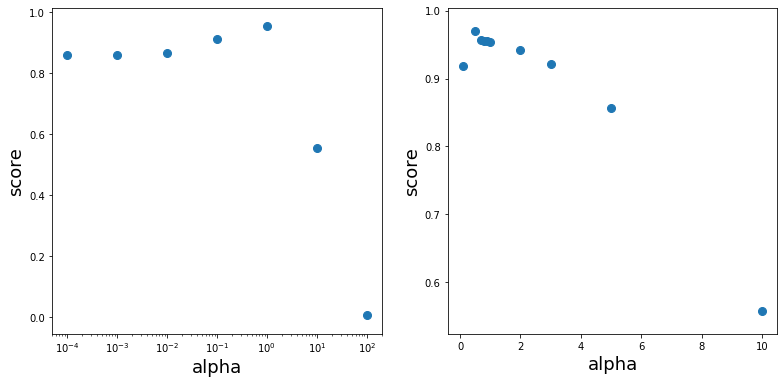

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

axes[0].scatter(alphas, r2s_alpha, alpha=1)
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('score')
axes[0].set_xscale('log')
axes[0].set_xlim(5e-5, 2e2)

axes[1].scatter(alphas_fine, r2s_alpha_fine, alpha=1)
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('score')

## Scaled X

In [38]:
alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])

parameter_set = {'alpha':alphas}

LASSO = Lasso(tol=1)
LASSO_search = GridSearchCV(LASSO, parameter_set, cv =kf)
LASSO_search.fit(X_train_test_scaled, y_train_test)
                     
best_alpha = LASSO_search.best_estimator_.alpha
r_2 = LASSO_search.best_score_
coeffs = LASSO_search.best_estimator_.coef_
nonzero = [f for f in np.isclose(coeffs,0) if f == True]
num_dropped = len(nonzero)

r2s_alpha = LASSO_search.cv_results_['mean_test_score']

    
print('Best alpha is: {}'.format(best_alpha))
print('r square is: {}'.format(r_2))
print('Number of dropped features: {}'.format(num_dropped))

#Second refinement
print('\n====== Second GridSearchCV Refinement ======\n')

alphas_fine = np.array([0.1, 0.5, 0.7, 0.8, 0.9, 1, 2, 3, 5, 10])

parameter_set = {'alpha':alphas_fine}

LASSO = Lasso(tol=1)
LASSO_search = GridSearchCV(LASSO, parameter_set, cv =kf)
LASSO_search.fit(X_train_test_scaled, y_train_test)
                     
best_alpha = LASSO_search.best_estimator_.alpha
r_2 = LASSO_search.best_score_
coeffs = LASSO_search.best_estimator_.coef_
nonzero = [f for f in np.isclose(coeffs,0) if f == True]
num_dropped = len(nonzero)

r2s_alpha_fine = LASSO_search.cv_results_['mean_test_score']
    
print('Best alpha is: {}'.format(best_alpha))
print('r square is: {}'.format(r_2))
print('Number of dropped features: {}'.format(num_dropped))
print(coeffs)

Best alpha is: 1.0
r square is: 0.8899277109056567
Number of dropped features: 33

====== Second GridSearchCV Refinement ======

Best alpha is: 0.5
r square is: 0.904418974611502
Number of dropped features: 32
[ 1.583 -0.     0.    -0.     0.    -0.    -0.    -0.     0.    -0.
  0.     0.     0.     0.     0.    -0.     0.    -0.    -0.    -0.
 -0.    -0.     0.    -0.     0.     0.    -0.     0.    -0.    -0.
  0.186  0.     0.     0.     2.199]


Text(0, 0.5, 'score')

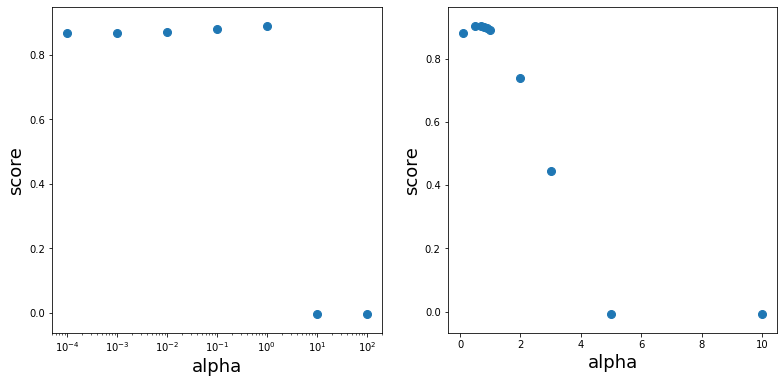

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

axes[0].scatter(alphas, r2s_alpha, alpha=1)
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('score')
axes[0].set_xscale('log')
axes[0].set_xlim(5e-5, 2e2)

axes[1].scatter(alphas_fine, r2s_alpha_fine, alpha=1)
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('score')

After rescaling x matirx accross data points, surprisingly, the performance of the model became slightly worse. But generally, multi-linear Lasso regression is a good appoach to shrink and largly simplify descriptors the with high accuracy (32 features are dropped based on the result, only two features are really important). This is a very exciting result that we can only use 3 most important features to describe gas uptakes for most of the cases!

## Comparison with Multi-Linear Model

[[ 0.04  -0.007 -0.845  0.349  0.401 -0.49  -0.267 -0.418  0.282 -0.086
  -0.217  0.401  0.006  0.262  0.177  0.071  0.126  0.258 -0.062 -0.063
   0.16   0.402  0.213  0.166  0.004  0.077  0.027 -0.138 -0.04   0.042
  -0.032 -0.131  0.125  0.034  3.985]]
[ 1.583 -0.     0.    -0.     0.    -0.    -0.    -0.     0.    -0.
  0.     0.     0.     0.     0.    -0.     0.    -0.    -0.    -0.
 -0.    -0.     0.    -0.     0.     0.    -0.     0.    -0.    -0.
  0.186  0.     0.     0.     2.199]


Text(0.5, 1.0, 'Multi-Linear Regression with Lasso')

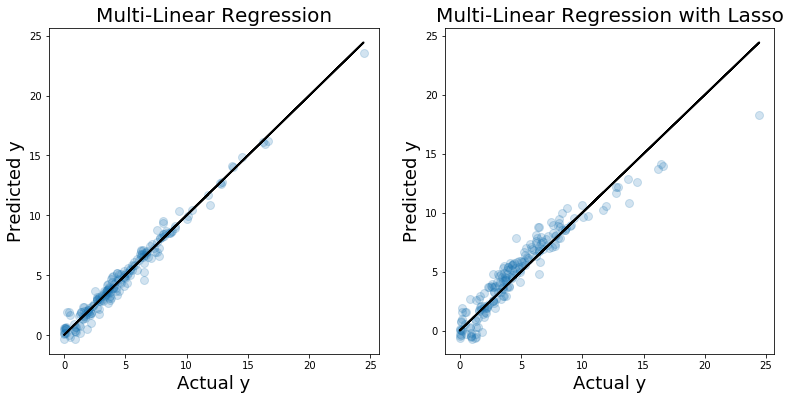

In [56]:
from sklearn.linear_model import LinearRegression

LR_model_scaled = LinearRegression()
LR_model_scaled.fit(X_train_test_scaled, y_train_test)

LASSO = Lasso(alpha=0.5,tol=1)
LASSO.fit(X_train_test_scaled, y_train_test)

y_hat_validation_LR = LR_model_scaled.predict(X_validation_scaled)
y_hat_validation_LASSO = LASSO.predict(X_validation_scaled).reshape(-1,1)

print(LR_model_scaled.coef_)
print(LASSO.coef_)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0].scatter(y_validation, y_hat_validation_LR, alpha=0.2)
axes[0].plot(y_validation, y_validation, '-k')
axes[0].set_xlabel('Actual y')
axes[0].set_ylabel('Predicted y')
axes[0].set_title('Multi-Linear Regression')

axes[1].scatter(y_validation, y_hat_validation_LASSO, alpha=0.2)
axes[1].plot(y_validation, y_validation, '-k')
axes[1].set_xlabel('Actual y')
axes[1].set_ylabel('Predicted y')
axes[1].set_title('Multi-Linear Regression with Lasso')

The above figures are comparision of actual and predicted y of validation set. We can draw a conclusion that by adding Lasso regulation, the model is much more simplified without losing a lot of prediction capability. This resolve the overfitting problem showed in our baseline model.

# LASSO Regression with RBF Kernel

## Unscaled X

In [10]:
sigmas = np.array([1E-4, 5E-4, 1E-3, 5E-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60])
gammas = 1./(2*sigmas**2)
r2_matrix = np.zeros((gammas.size, 4))

alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
parameter_set = {'alpha':alphas}

     
for j, gamma in enumerate(gammas):
    
    X_train_kernel = rbf_kernel(X_train_test, X_train_test, gamma = gamma)
        
    LASSO = Lasso(tol=1)
    LASSO_search = GridSearchCV(LASSO, parameter_set, cv =kf)
    LASSO_search.fit(X_train_kernel, y_train_test)

    r2_matrix[j, 0] = gamma
    r2_matrix[j, 1] = LASSO_search.best_estimator_.alpha
    r2_matrix[j, 2] = LASSO_search.best_score_
    coeffs = LASSO_search.best_estimator_.coef_
    nonzero = [f for f in np.isclose(coeffs,0) if f == True]
    num_dropped = len(nonzero)
    r2_matrix[j, -1] = int(num_dropped)
        
n = r2_matrix[:, 2].argmax()
print(r2_matrix)

print('Best gamma is: {:.0e}'.format(r2_matrix[n,0]))
print('Best alpha is: {:.0e}'.format(r2_matrix[n,1]))
print('r square is: {:.3f}'.format(r2_matrix[n,2]))
print('Number of dropped features: {}'.format(r2_matrix[n,-1]))


#Second refinement
print('\n====== Second GridSearchCV Refinement ======\n')

sigmas = np.array([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
gammas = 1./(2*sigmas**2)
r2_matrix = np.zeros((gammas.size, 4))

alphas = np.array([1e-4, 5e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 5e-3, 7e-3])
parameter_set = {'alpha':alphas}

     
for j, gamma in enumerate(gammas):
    
    X_train_kernel = rbf_kernel(X_train_test, X_train_test, gamma = gamma)
        
    LASSO = Lasso(tol=1)
    LASSO_search = GridSearchCV(LASSO, parameter_set, cv =kf)
    LASSO_search.fit(X_train_kernel, y_train_test)

    r2_matrix[j, 0] = gamma
    r2_matrix[j, 1] = LASSO_search.best_estimator_.alpha
    r2_matrix[j, 2] = LASSO_search.best_score_
    coeffs = LASSO_search.best_estimator_.coef_
    nonzero = [f for f in np.isclose(coeffs,0) if f == True]
    num_dropped = len(nonzero)
    r2_matrix[j, -1] = int(num_dropped)
        
n = r2_matrix[:, 2].argmax()
print(r2_matrix)

print('Best gamma is: {:.0e}'.format(r2_matrix[n,0]))
print('Best alpha is: {:.0e}'.format(r2_matrix[n,1]))
print('r square is: {:.3f}'.format(r2_matrix[n,2]))
print('Number of dropped features: {}'.format(r2_matrix[n,-1]))

[[50000000.           0.          -0.005        9.   ]
 [ 2000000.           0.          -0.005        9.   ]
 [  500000.           0.          -0.012        9.   ]
 [   20000.           0.1         -0.009      600.   ]
 [    5000.           0.001       -0.014       77.   ]
 [     200.           0.001        0.006       75.   ]
 [      50.           0.001        0.007       78.   ]
 [       2.           0.001        0.042       85.   ]
 [       0.5          0.001        0.038       94.   ]
 [       0.02         0.01         0.175      492.   ]
 [       0.005        0.001        0.488      104.   ]
 [       0.002        0.001        0.473       92.   ]
 [       0.001        0.           0.407        1.   ]
 [       0.001        0.           0.258        0.   ]
 [       0.001        0.           0.244        1.   ]
 [       0.           0.001        0.219      129.   ]
 [       0.           0.           0.159        2.   ]
 [       0.           0.01         0.125      475.   ]]
Best gamm

Not surprisingly, unscaled X results in poor r square performances. We want to address here that using rbf kernel matrix seems to be unclever because it averages out each row into a single value (i.e. assuming all features have same contributions). Apparently, ignoring physical meanings of descriptors causes huge problem. 

## Scaled X

In [11]:
sigmas = np.array([1E-4, 5E-4, 1E-3, 5E-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60])
gammas = 1./(2*sigmas**2)
r2_matrix = np.zeros((gammas.size, 4))

alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
parameter_set = {'alpha':alphas}

     
for j, gamma in enumerate(gammas):
    
    X_train_kernel = rbf_kernel(X_train_test_scaled, X_train_test_scaled, gamma = gamma)
        
    LASSO = Lasso(tol=1)
    LASSO_search = GridSearchCV(LASSO, parameter_set, cv =kf)
    LASSO_search.fit(X_train_kernel, y_train_test)

    r2_matrix[j, 0] = gamma
    r2_matrix[j, 1] = LASSO_search.best_estimator_.alpha
    r2_matrix[j, 2] = LASSO_search.best_score_
    coeffs = LASSO_search.best_estimator_.coef_
    nonzero = [f for f in np.isclose(coeffs,0) if f == True]
    num_dropped = len(nonzero)
    r2_matrix[j, -1] = num_dropped
        
n = r2_matrix[:, 2].argmax()
print(r2_matrix)

print('Best gamma is: {:.0e}'.format(r2_matrix[n,0]))
print('Best alpha is: {:.0e}'.format(r2_matrix[n,1]))
print('r square is: {:.3f}'.format(r2_matrix[n,2]))
print('Number of dropped features: {}'.format(r2_matrix[n,-1]))


#Second refinement
print('\n====== Second GridSearchCV Refinement ======\n')

sigmas = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
gammas = 1./(2*sigmas**2)
r2_matrix = np.zeros((gammas.size, 4))

alphas = np.array([1e-5, 2e-5, 3e-5, 4e-5, 5e-5])
parameter_set = {'alpha':alphas}

     
for j, gamma in enumerate(gammas):
    
    X_train_kernel = rbf_kernel(X_train_test_scaled, X_train_test_scaled, gamma = gamma)
        
    LASSO = Lasso(tol=1)
    LASSO_search = GridSearchCV(LASSO, parameter_set, cv =kf)
    LASSO_search.fit(X_train_kernel, y_train_test)

    r2_matrix[j, 0] = gamma
    r2_matrix[j, 1] = LASSO_search.best_estimator_.alpha
    r2_matrix[j, 2] = LASSO_search.best_score_
    coeffs = LASSO_search.best_estimator_.coef_
    nonzero = [f for f in np.isclose(coeffs,0) if f == True]
    num_dropped = len(nonzero)
    r2_matrix[j, -1] = num_dropped
        
n = r2_matrix[:, 2].argmax()
print(r2_matrix)
print(coeffs.shape)

print('Best gamma is: {:.0e}'.format(r2_matrix[n,0]))
print('Best alpha is: {:.0e}'.format(r2_matrix[n,1]))
print('r square is: {:.3f}'.format(r2_matrix[n,2]))
print('Number of dropped features: {}'.format(r2_matrix[n,-1]))

[[50000000.           0.          -0.008        9.   ]
 [ 2000000.           0.1         -0.016      600.   ]
 [  500000.           0.1         -0.002      600.   ]
 [   20000.           0.          -0.012        9.   ]
 [    5000.           0.          -0.001        9.   ]
 [     200.           0.001        0.011       77.   ]
 [      50.           0.001        0.026       85.   ]
 [       2.           0.01         0.058      528.   ]
 [       0.5          0.01         0.179      494.   ]
 [       0.02         0.           0.943        0.   ]
 [       0.005        0.           0.922        0.   ]
 [       0.002        0.           0.911        2.   ]
 [       0.001        0.           0.909        1.   ]
 [       0.001        0.           0.911        2.   ]
 [       0.001        0.           0.903        8.   ]
 [       0.           0.           0.907       11.   ]
 [       0.           0.           0.909       17.   ]
 [       0.           0.           0.896       24.   ]]
Best gamm

After rescaling x matirx accross data points, there is a huge improvement of model performance. However, just 1 of the 600 features is dropped (non-parametric model), and optimal alpha values all very small, i.e. the model is not simplified. Here is one thing that we can do for our final report: Considering the trade-off between precision and model simplification. The goal of this work is to predict the gas uptate by feature of MOFs and adsorbates with very high accuracy. But from experimental aspect, it is definitely much more convenient if a relatively small amount of descriptors could sufficiently predict gas uptakes since features could be difficult and time-consuming to be obtained experimentally.

For future work, I think **forward selection** is a good way to see if the dropped features of two methods are similar. 